# **Waze Project**


In [31]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from xgboost import plot_importance

import pickle

In [32]:
df = pd.read_csv('waze_dataset.csv')

In [33]:
# Takigng a copy of the dataset for later use

df0 = df.copy()


### Understanding the data

In [ ]:
df.head(10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


There are 14,999 rows and 13 columns. he dataset has 700 missing values in the `label` column.

I will compare the summary statistics of the 700 rows that are missing labels with summary statistics of the rows that are not missing any values.

In [5]:
null_df = df[df['label'].isnull()]
null_df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,7405.584286,80.837143,67.798571,198.483348,1709.295714,118.717143,30.371429,3935.967029,1795.123358,15.382857,12.125714
std,4306.900234,79.987440,65.271926,140.561715,1005.306562,156.308140,46.306984,2443.107121,1419.242246,8.772714,7.626373
min,77.000000,0.000000,0.000000,5.582648,16.000000,0.000000,0.000000,290.119811,66.588493,0.000000,0.000000
25%,3744.500000,23.000000,20.000000,94.056340,869.000000,4.000000,0.000000,2119.344818,779.009271,8.000000,6.000000
50%,7443.000000,56.000000,47.500000,177.255925,1650.500000,62.500000,10.000000,3421.156721,1414.966279,15.000000,12.000000
75%,11007.000000,112.250000,94.000000,266.058022,2508.750000,169.250000,43.000000,5166.097373,2443.955404,23.000000,18.000000
max,14993.000000,556.000000,445.000000,1076.879741,3498.000000,1096.000000,352.000000,15135.391280,9746.253023,31.000000,30.000000


In [6]:
not_null_df = df[~df['label'].isnull()]
not_null_df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,7503.573117,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530
std,4331.207621,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000
50%,7504.000000,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000
75%,11257.500000,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


Comparing summary statistics of the observations with missing retention labels with those that aren't missing any values reveals nothing remarkable. The means and standard deviations are fairly consistent between the two groups.

Next, I will check the two populations with respect to the `device` variable.

In [7]:
null_df['device'].value_counts()

iPhone     447
Android    253
Name: device, dtype: int64

In [8]:
null_df['device'].value_counts(normalize=True)

iPhone     0.638571
Android    0.361429
Name: device, dtype: float64

Of the 700 rows with null values, 447 were iPhone users and 253 were Android users. That is a around 64% and 36%.

In [9]:
df['device'].value_counts(normalize=True)

iPhone     0.644843
Android    0.355157
Name: device, dtype: float64

The percentage of missing values by each device is consistent with their representation in the data overall.

There is nothing to suggest a non-random cause of the missing data.

Now, I will examine the counts and percentages of users who churned vs. those who were retained.

In [10]:
print(df['label'].value_counts())
print()
print(df['label'].value_counts(normalize=True))

retained    11763
churned      2536
Name: label, dtype: int64

retained    0.822645
churned     0.177355
Name: label, dtype: float64


This dataset contains 82% retained users and 18% churned users.

Next, compare the medians of each variable for churned and retained users. 

In [11]:
df.groupby('label').median(numeric_only=True)

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
label,,,,,,,,,,,
churned,7477.5,59.0,50.0,164.339042,1321.0,84.5,11.0,3652.655666,1607.183785,8.0,6.0
retained,7509.0,56.0,47.0,157.586756,1843.0,68.0,9.0,3464.684614,1458.046141,17.0,14.0


Users who churned averaged ~3 more drives in the last month than retained users, but retained users used the app on over twice as many days as churned users in the same time period.

The median churned user drove ~200 more kilometers and 2.5 more hours during the last month than the median retained user.

It seems that churned users had more drives in fewer days, and their trips were farther and longer in duration. Perhaps this is suggestive of a user profile.

To continue exploring this, I will calculate the median kilometers per drive in the last month for both retained and churned users.

In [12]:
medians_by_label = df.groupby('label').median(numeric_only=True)
print('Median kilometers per drive:')
medians_by_label['driven_km_drives'] / medians_by_label['drives']

Median kilometers per drive:


label
churned     73.053113
retained    73.716694
dtype: float64

The median user from both groups drove ~73 km/drive. 

In [13]:
print('Median kilometers per driving day:')
medians_by_label['driven_km_drives'] / medians_by_label['driving_days']

Median kilometers per driving day:


label
churned     608.775944
retained    247.477472
dtype: float64

In [14]:
print('Median drives per driving day:')
medians_by_label['drives'] / medians_by_label['driving_days']

Median drives per driving day:


label
churned     8.333333
retained    3.357143
dtype: float64

The median user who churned drove 608 kilometers each day last month, which is almost 250% the per-drive-day distance of retained users. The median churned user had a similarly disproporionate number of drives per drive day compared to retained users.

It is clear from these figures that, regardless of whether a user churned or not, the users represented in this data are serious drivers! It would probably be safe to assume that this data does not represent typical drivers at large. Perhaps the data&mdash;and in particular the sample of churned users&mdash;contains a high proportion of long-haul truckers.

In consideration of how much these users drive, it would be worthwhile to recommend to Waze that they gather more data on these super-drivers. It's possible that the reason for their driving so much is also the reason why the Waze app does not meet their specific set of needs, which may differ from the needs of a more typical driver, such as a commuter.

Further, I will examine whether there is an imbalance in how many users churned by device type.

In [15]:
df.groupby(['label', 'device']).size()

label     device 
churned   Android     891
          iPhone     1645
retained  Android    4183
          iPhone     7580
dtype: int64

In [16]:
df.groupby('label')['device'].value_counts(normalize=True)

label     device 
churned   iPhone     0.648659
          Android    0.351341
retained  iPhone     0.644393
          Android    0.355607
Name: device, dtype: float64

The ratio of iPhone users and Android users is consistent between the churned group and the retained group, and those ratios are both consistent with the ratio found in the overall dataset.

### Exploring variables

#### **`sessions`**

_The number of occurrences of a user opening the app during the month_

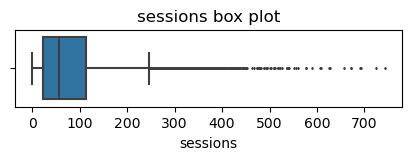

In [17]:
plt.figure(figsize=(5,1))
sns.boxplot(x=df['sessions'], fliersize=1)
plt.title('sessions box plot');

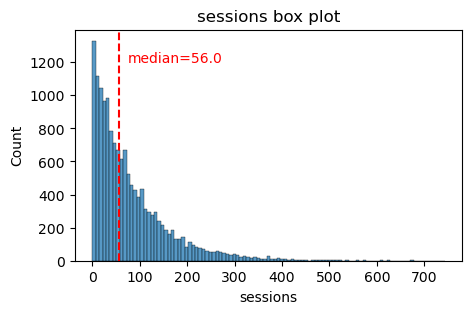

In [18]:
plt.figure(figsize=(5,3))
sns.histplot(x=df['sessions'])
median = df['sessions'].median()
plt.axvline(median, color='red', linestyle='--')
plt.text(75,1200, 'median=56.0', color='red')
plt.title('sessions box plot');

The `sessions` variable is a right-skewed distribution with half of the observations having 56 or fewer sessions. However, as indicated by the boxplot, some users have more than 700.

#### **`drives`**

_An occurrence of driving at least 1 km during the month_

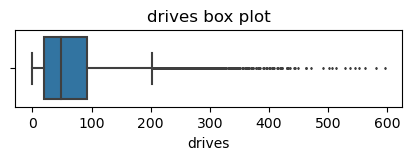

In [19]:
plt.figure(figsize=(5,1))
sns.boxplot(x=df['drives'], fliersize=1)
plt.title('drives box plot');

In [20]:
# As I will be plotting histograms, I will create a helper function to plot histograms based on the
def histogrammer(column_str, median_text=True, **kwargs):  
                                                        
    median=round(df[column_str].median(), 1)
    plt.figure(figsize=(5,3))
    ax = sns.histplot(x=df[column_str], **kwargs)           
    plt.axvline(median, color='red', linestyle='--')        
    if median_text==True:                                    
        ax.text(0.25, 0.85, f'median={median}', color='red',
            ha='left', va='top', transform=ax.transAxes)
    else:
        print('Median:', median)
    plt.title(f'{column_str} histogram');

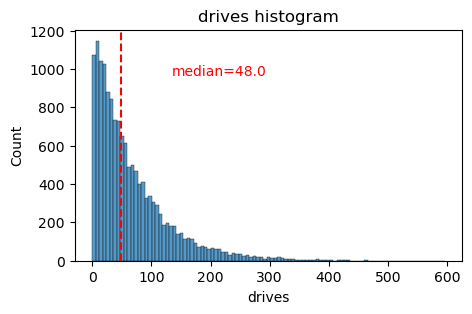

In [21]:
histogrammer('drives')

The `drives` information follows a distribution similar to the `sessions` variable. It is right-skewed, approximately log-normal, with a median of 48. However, some drivers had over 400 drives in the last month.

#### **`total_sessions`**

_A model estimate of the total number of sessions since a user has onboarded_

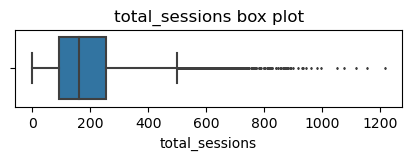

In [22]:
plt.figure(figsize=(5,1))
sns.boxplot(x=df['total_sessions'], fliersize=1)
plt.title('total_sessions box plot');

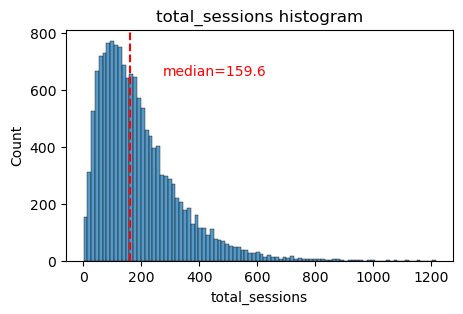

In [23]:
histogrammer('total_sessions')

The `total_sessions` is a right-skewed distribution. The median total number of sessions is 159.6. This is interesting information because, if the median number of sessions in the last month was 56 and the median total sessions was ~160, then it seems that a large proportion of a user's (estimated) total drives might have taken place in the last month. This is something I can examine more closely later.

#### **`n_days_after_onboarding`**

_The number of days since a user signed up for the app_

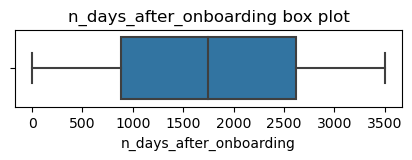

In [24]:
plt.figure(figsize=(5,1))
sns.boxplot(x=df['n_days_after_onboarding'], fliersize=1)
plt.title('n_days_after_onboarding box plot');

Median: 1741.0


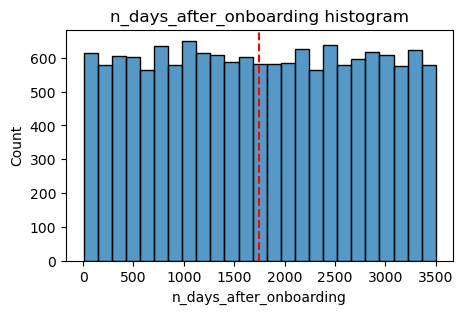

In [25]:
histogrammer('n_days_after_onboarding', median_text=False)

The total user tenure (i.e., number of days since
onboarding) is a uniform distribution with values ranging from near-zero to \~3,500 (\~9.5 years).

#### **`driven_km_drives`**

_Total kilometers driven during the month_

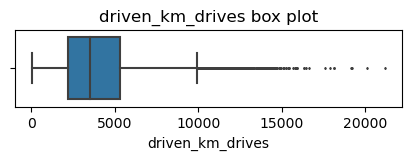

In [26]:
plt.figure(figsize=(5,1))
sns.boxplot(x=df['driven_km_drives'], fliersize=1)
plt.title('driven_km_drives box plot');

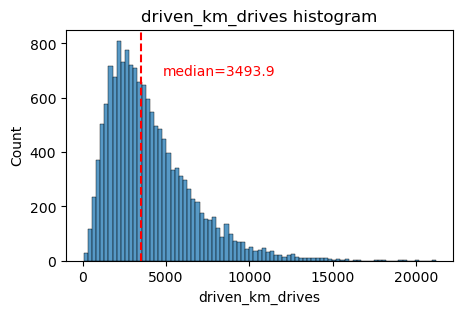

In [27]:
histogrammer('driven_km_drives')

The number of drives driven in the last month per user is a right-skewed distribution with half the users driving under 3,495 kilometers. As discovered in the analysis from the previous course, the users in this dataset drive _a lot_. The longest distance driven in the month was over half the circumferene of the earth.

#### **`duration_minutes_drives`**

_Total duration driven in minutes during the month_

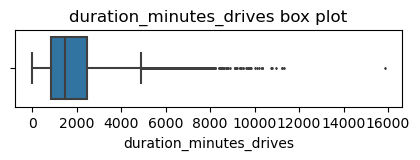

In [28]:
plt.figure(figsize=(5,1))
sns.boxplot(x=df['duration_minutes_drives'], fliersize=1)
plt.title('duration_minutes_drives box plot');

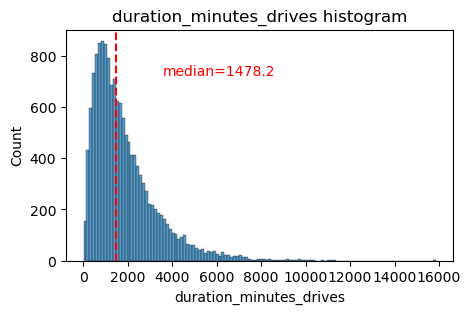

In [29]:
histogrammer('duration_minutes_drives')

The `duration_minutes_drives` variable has a heavily skewed right tail. Half of the users drove less than \~1,478 minutes (\~25 hours), but some users clocked over 250 hours over the month.

#### **`activity_days`**

_Number of days the user opens the app during the month_

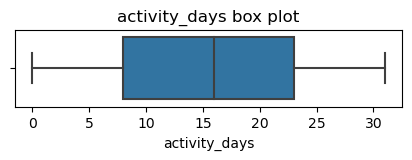

In [30]:
plt.figure(figsize=(5,1))
sns.boxplot(x=df['activity_days'], fliersize=1)
plt.title('activity_days box plot');

Median: 16.0


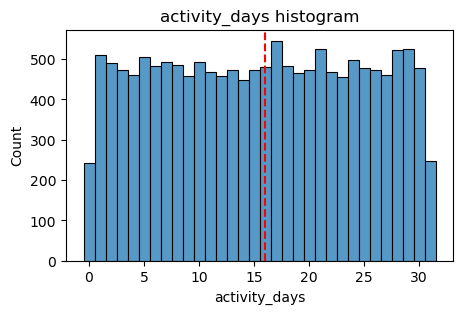

In [31]:
histogrammer('activity_days', median_text=False, discrete=True)

Within the last month, users opened the app a median of 16 times. The box plot reveals a centered distribution. The histogram shows a nearly uniform distribution of ~500 people opening the app on each count of days. However, there are ~250 people who didn't open the app at all and ~250 people who opened the app every day of the month.

This distribution is noteworthy because it does not mirror the `sessions` distribution, which you might think would be closely correlated with `activity_days`.

#### **`driving_days`**

_Number of days the user drives (at least 1 km) during the month_

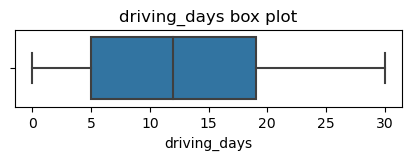

In [32]:
plt.figure(figsize=(5,1))
sns.boxplot(x=df['driving_days'], fliersize=1)
plt.title('driving_days box plot');

Median: 12.0


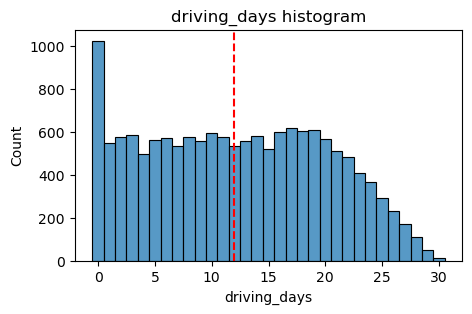

In [33]:
histogrammer('driving_days', median_text=False, discrete=True)

The number of days users drove each month is almost uniform, and it largely correlates with the number of days they opened the app that month, except the `driving_days` distribution tails off on the right.

However, there were almost twice as many users (\~1,000 vs. \~550) who did not drive at all during the month. This might seem counterintuitive when considered together with the information from `activity_days`. That variable had \~500 users opening the app on each of most of the day counts, but there were only \~250 users who did not open the app at all during the month and ~250 users who opened the app every day. This is flagged  for further investigation later.

#### **`device`**

_The type of device a user starts a session with_


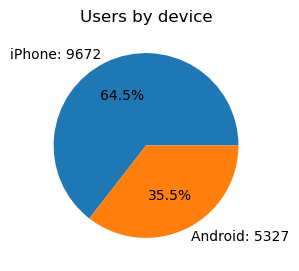

In [34]:
fig = plt.figure(figsize=(3,3))
data=df['device'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%'
        )
plt.title('Users by device');

There are nearly twice as many iPhone users as Android users represented in this data.

#### **`label`**

_Binary target variable (“retained” vs “churned”) for if a user has churned anytime during the course of the month_

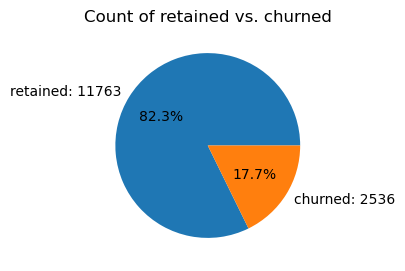

In [35]:
fig = plt.figure(figsize=(3,3))
data=df['label'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%'
        )
plt.title('Count of retained vs. churned');

Less than 18% of the users churned.

#### **`driving_days` vs. `activity_days`**

Because both `driving_days` and `activity_days` represent counts of days over a month and they're also closely related, I can plot them together on a single histogram.

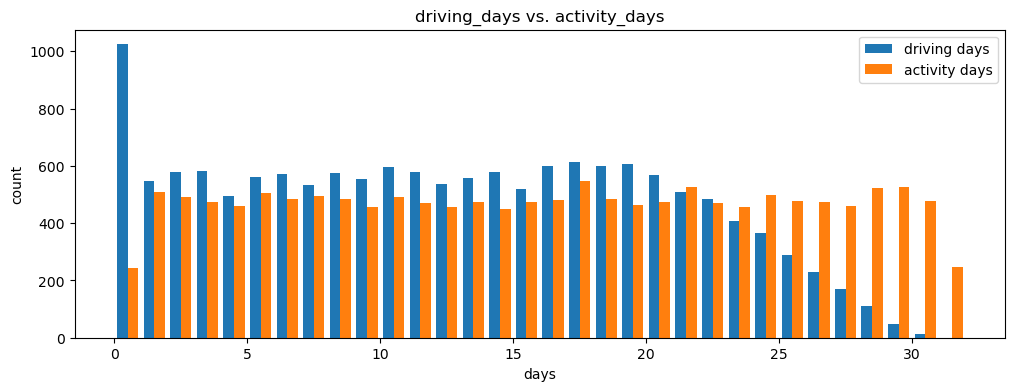

In [36]:
plt.figure(figsize=(12,4))
label=['driving days', 'activity days']
plt.hist([df['driving_days'], df['activity_days']],
         bins=range(0,33),
         label=label)
plt.xlabel('days')
plt.ylabel('count')
plt.legend()
plt.title('driving_days vs. activity_days');

As observed previously, this might seem counterintuitive. After all, why are there _fewer_ people who didn't use the app at all during the month and _more_ people who didn't drive at all during the month?

On the other hand, it could just be illustrative of the fact that, while these variables are related to each other, they're not the same. People probably just open the app more than they use the app to drive&mdash;perhaps to check drive times or route information, to update settings, or even just by mistake.

Now, I would like to confirm the maximum number of days for each variable&mdash;`driving_days` and `activity_days`.

In [37]:
print(df['driving_days'].max())
print(df['activity_days'].max())

30
31


It's true. Although it's possible that not a single user drove all 31 days of the month, it's highly unlikely, considering there are 15,000 people represented in the dataset.

One other way to check the validity of these variables is to plot a simple scatter plot of both variables

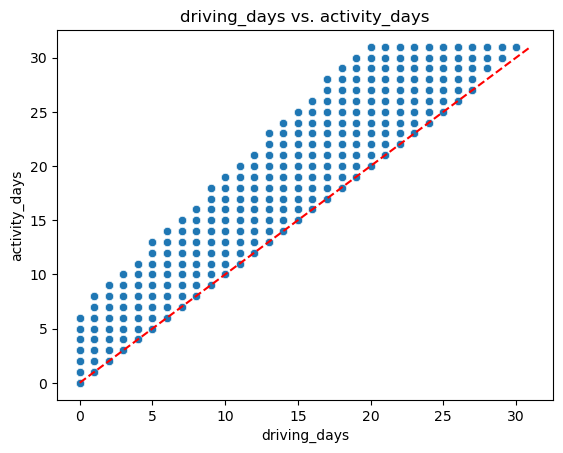

In [38]:
sns.scatterplot(data=df, x='driving_days', y='activity_days')
plt.title('driving_days vs. activity_days')
plt.plot([0,31], [0,31], color='red', linestyle='--');

Notice that there is a theoretical limit. If you use the app to drive, then by definition it must count as a day-use as well. In other words, you cannot have more drive-days than activity-days. None of the samples in this data violate this rule, which is good.

#### **Retention by device**

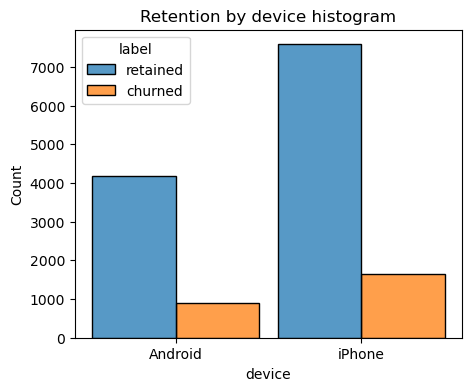

In [39]:
plt.figure(figsize=(5,4))
sns.histplot(data=df,
             x='device',
             hue='label',
             multiple='dodge',
             shrink=0.9
             )
plt.title('Retention by device histogram');

The proportion of churned users to retained users is consistent between device types.

#### **Retention by kilometers driven per driving day**


In [40]:
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

The mean value is infinity, the standard deviation is NaN, and the max value is infinity. 

This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined. I will use numpy's `inf` to address this.


In [41]:
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

The maximum value is 15,420 kilometers _per drive day_. This is physically impossible. Driving 100 km/hour for 12 hours is 1,200 km. It's unlikely many people averaged more than this each day they drove, so, for now, I will disregard rows where the distance in this column is greater than 1,200 km.

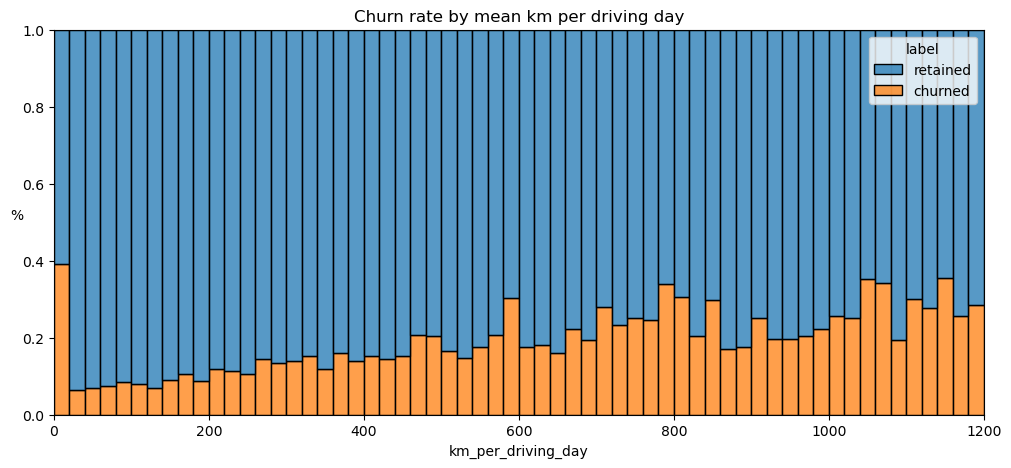

In [42]:
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='km_per_driving_day',
             bins=range(0,1201,20),
             hue='label',
             multiple='fill')
plt.ylabel('%', rotation=0)
plt.title('Churn rate by mean km per driving day');

The churn rate tends to increase as the mean daily distance driven increases, confirming what was found in the previous analysis. It would be worth investigating further the reasons for long-distance users to discontinue using the app.

#### **Churn rate per number of driving days**


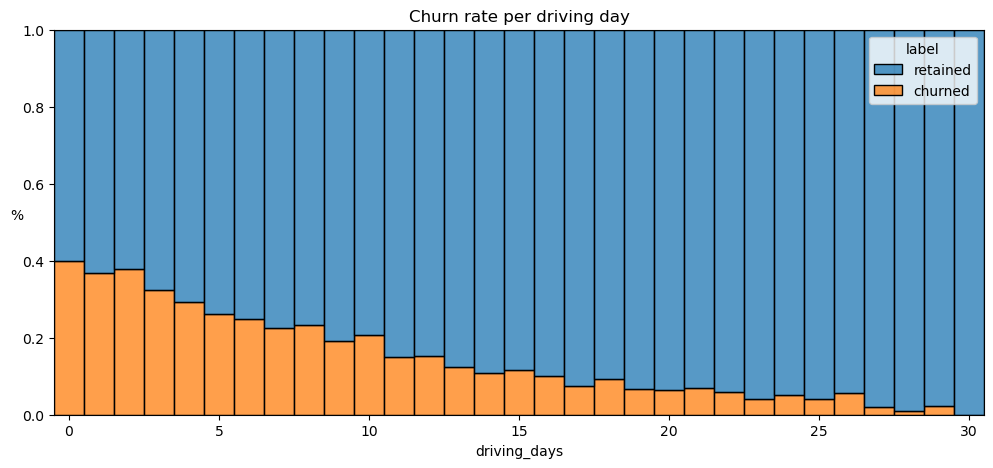

In [43]:
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='driving_days',
             bins=range(1,32),
             hue='label',
             multiple='fill',
             discrete=True)
plt.ylabel('%', rotation=0)
plt.title('Churn rate per driving day');

The churn rate is highest for people who didn't use Waze much during the last month. The more times they used the app, the less likely they were to churn. While 40% of the users who didn't use the app at all last month churned, nobody who used the app 30 days churned.

This isn't surprising. If people who used the app a lot churned, it would likely indicate dissatisfaction. When people who don't use the app churn, it might be the result of dissatisfaction in the past, or it might be indicative of a lesser need for a navigational app. Maybe they moved to a city with good public transportation and don't need to drive anymore.

#### **Proportion of sessions that occurred in the last month**

In [44]:
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

In [45]:
df['percent_sessions_in_last_month'].median()

0.42309702992763176

Median: 0.4


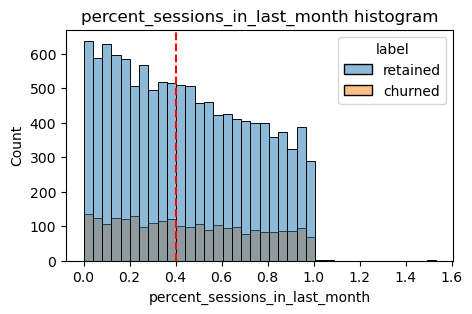

In [46]:
histogrammer('percent_sessions_in_last_month',
             hue=df['label'],
             multiple='layer',
             median_text=False)

In [47]:
df['n_days_after_onboarding'].median()

1741.0

Half of the people in the dataset had 40% or more of their sessions in just the last month, yet the overall median time since onboarding is almost five years.

Now, I will make a histogram of `n_days_after_onboarding` for just the people who had 40% or more of their total sessions in the last month.

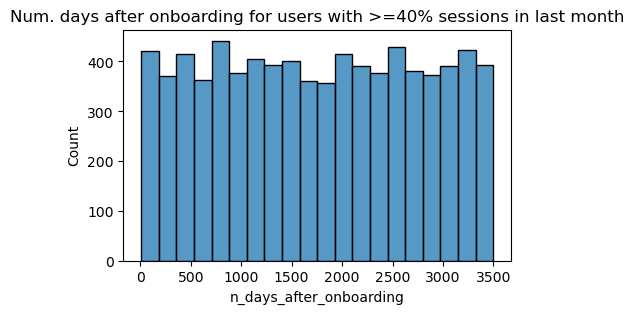

In [48]:
data = df.loc[df['percent_sessions_in_last_month']>=0.4]
plt.figure(figsize=(5,3))
sns.histplot(x=data['n_days_after_onboarding'])
plt.title('Num. days after onboarding for users with >=40% sessions in last month');

The number of days since onboarding for users with 40% or more of their total sessions occurring in just the last month is a uniform distribution. This is very strange. It's worth asking why so many long-time users suddenly used the app so much in the last month.

### **Handling outliers**

The box plots from the previous section indicated that many of these variables have outliers. These outliers do not seem to be data entry errors; they are present because of the right-skewed distributions. I will impute oultiers with the 95th percentile value.

In [49]:
def outlier_imputer(column_name, percentile):
    threshold = df[column_name].quantile(percentile)
    df.loc[df[column_name] > threshold, column_name] = threshold

    print('{:>25} | percentile: {} | threshold: {}'.format(column_name, percentile, threshold))

In [50]:
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
               outlier_imputer(column, 0.95)

                 sessions | percentile: 0.95 | threshold: 243.0
                   drives | percentile: 0.95 | threshold: 201.0
           total_sessions | percentile: 0.95 | threshold: 454.3632037399997
   total_navigations_fav1 | percentile: 0.95 | threshold: 424.0
   total_navigations_fav2 | percentile: 0.95 | threshold: 124.0
         driven_km_drives | percentile: 0.95 | threshold: 8889.7942356
  duration_minutes_drives | percentile: 0.95 | threshold: 4668.899348999998


In [51]:
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,76.568705,64.058204,184.031320,1749.837789,114.415228,27.214281,3939.632764,1789.647426,15.537102,12.179879,578.963113,0.449255
std,4329.982679,67.297958,55.306924,118.600463,1008.513876,124.686795,36.735583,2216.041510,1222.705167,9.004655,7.824036,1030.094384,0.286919
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,136.238895,0.196221
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,272.889272,0.423097
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,558.686918,0.687216
max,14998.000000,243.000000,201.000000,454.363204,3500.000000,424.000000,124.000000,8889.794236,4668.899349,31.000000,30.000000,15420.234110,1.530637


In [52]:
df['monthly_drives_per_session_ratio'] = (df['drives']/df['sessions'])

In [53]:
df.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,monthly_drives_per_session_ratio
0,0,retained,243,201,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,0.827160
1,1,retained,133,107,326.896596,1225,19,64,8889.794236,3160.472914,13,11,iPhone,1246.901868,0.406856,0.804511
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0.833333
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0.816327
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,0.809524
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone,81.930791,0.404229,0.911504
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone,228.224906,0.012673,0.666667
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone,394.602623,0.221499,0.897436
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android,132.585488,0.310573,0.807018
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone,2014.486765,0.343134,0.809524


#### **Conclusion**

> Analysis revealed that the overall churn rate is \~17%, and that this rate is consistent between iPhone users and Android users.

> Also, it was revealed that users who drive very long distances on their driving days are _more_ likely to churn, but users who drive more often are _less_ likely to churn.

## Difference between mean amount of rides between Iphone and Andriod users.

At this stage, I would like to do a statistical analysis of ride data based on device type. In particular, I want to know if there is a statistically significant difference in mean amount of rides between iPhone® users and Android™ users. For that purpose, I will conduct a two-sample hypothesis test (t-test) to analyze the difference in the mean amount of rides between iPhone users and Android users.


In the dataset, `device` is a categorical variable with the labels `iPhone` and `Android`.

In order to perform this analysis, I will turn each label into an integer.  The following code assigns a `1` for an `iPhone` user and a `2` for `Android`.

In [54]:
map_dictionary = {'Android': 2, 'iPhone': 1}

df['device_type'] = df['device']

df['device_type'] = df['device_type'].map(map_dictionary)

df['device_type'].head()

0    2
1    1
2    2
3    1
4    2
Name: device_type, dtype: int64

In [55]:
df.groupby('device_type')['drives'].mean()

device_type
1    64.446340
2    63.353482
Name: drives, dtype: float64

Based on the averages shown, it appears that drivers who use an iPhone device to interact with the application have a higher number of drives on average. However, this difference might arise from random sampling, rather than being a true difference in the number of drives. To assess whether the difference is statistically significant, I will conduct a hypothesis test with 5% as significant level.

### Hypothesis testing

$H_0$: There is no difference in average number of drives between drivers who use iPhone devices and drivers who use Androids.

$H_A$: There is a difference in average number of drives between drivers who use iPhone devices and drivers who use Androids.

In [56]:
iPhone = df[df['device_type'] == 1]['drives']

Android = df[df['device_type'] == 2]['drives']

stats.ttest_ind(a=iPhone, b=Android, equal_var=False)

Ttest_indResult(statistic=1.1643714136026293, pvalue=0.24429844267242223)

> *Since the p-value is larger than the chosen significance level (5%), I fail to reject the null hypothesis, concluding that there is **not** a statistically significant difference in the average number of drives between drivers who use iPhones and drivers who use Androids.*

> *The key business insight is that drivers who use iPhone devices on average have a similar number of drives as those who use Androids.*

## Predicting users' churn based on multiple features: logistic regression

In [57]:
df['label'].value_counts(normalize=True)

retained    0.822645
churned     0.177355
Name: label, dtype: float64

### professional_driver

I have engineered a feature earlier in the notebook called `km_per_driving_day` that can potentially be useful for the model building. Now, I want create a binary feature called `professional_driver` that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.

In [58]:
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

In [59]:
print(df['professional_driver'].value_counts())

df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

0    12405
1     2594
Name: professional_driver, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: label, dtype: float64

The churn rate for professional drivers is 7.6%, while the churn rate for non-professionals is 19.9%. This seems like it could add predictive signal to the model.

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                14999 non-null  int64  
 1   label                             14299 non-null  object 
 2   sessions                          14999 non-null  int64  
 3   drives                            14999 non-null  int64  
 4   total_sessions                    14999 non-null  float64
 5   n_days_after_onboarding           14999 non-null  int64  
 6   total_navigations_fav1            14999 non-null  int64  
 7   total_navigations_fav2            14999 non-null  int64  
 8   driven_km_drives                  14999 non-null  float64
 9   duration_minutes_drives           14999 non-null  float64
 10  activity_days                     14999 non-null  int64  
 11  driving_days                      14999 non-null  int64  
 12  devi

We know from EDA that there is no evidence of a non-random cause of the 700 missing values in the `label` column, and because these observations comprise less than 5% of the data, I will drop rows with the missing values.

In [61]:
df = df.dropna(subset=['label', 'monthly_drives_per_session_ratio'])

### Encoding catagorical variables

In [62]:
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


### Checking correlation among predictor variables

In [63]:
df.corr(method='pearson')

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month,monthly_drives_per_session_ratio,device_type,professional_driver,label2
ID,1.000000,0.011345,0.010488,0.005961,-0.004378,0.000155,-0.004080,0.000432,0.001661,-0.001698,-0.001967,-0.004708,0.009303,-0.007608,0.012969,0.012343,0.004705
sessions,0.011345,1.000000,0.996911,0.597850,0.007257,0.002408,0.007689,0.004582,-0.002361,0.024280,0.019588,-0.010604,0.609584,-0.356005,-0.011266,0.442310,0.034349
drives,0.010488,0.996911,1.000000,0.596164,0.007107,0.001569,0.008656,0.005075,-0.001655,0.023494,0.018879,-0.009981,0.609290,-0.307779,-0.010222,0.442663,0.035379
total_sessions,0.005961,0.597850,0.596164,1.000000,0.006593,0.000634,0.009634,0.002285,0.000603,0.014956,0.012143,-0.014303,-0.121718,-0.205398,-0.012037,0.253892,0.024291
n_days_after_onboarding,-0.004378,0.007257,0.007107,0.006593,1.000000,-0.002679,-0.004820,-0.005924,-0.011065,-0.009888,-0.008021,0.010049,-0.000756,0.000995,0.010200,0.003826,-0.128840
total_navigations_fav1,0.000155,0.002408,0.001569,0.000634,-0.002679,1.000000,0.002150,-0.006772,0.006271,0.012125,0.011725,0.000599,0.016120,-0.020649,0.002996,0.000009,0.052890
total_navigations_fav2,-0.004080,0.007689,0.008656,0.009634,-0.004820,0.002150,1.000000,0.003635,-0.003079,-0.004393,0.001727,0.005787,-0.000660,0.003043,0.000384,0.006789,0.013583
driven_km_drives,0.000432,0.004582,0.005075,0.002285,-0.005924,-0.006772,0.003635,1.000000,0.689796,-0.007000,-0.009205,0.344436,0.000046,0.000507,0.001977,-0.000278,0.019914
duration_minutes_drives,0.001661,-0.002361,-0.001655,0.000603,-0.011065,0.006271,-0.003079,0.689796,1.000000,-0.006841,-0.008633,0.238035,-0.004911,0.019937,0.007567,-0.011301,0.040412
activity_days,-0.001698,0.024280,0.023494,0.014956,-0.009888,0.012125,-0.004393,-0.007000,-0.006841,1.000000,0.947730,-0.398797,0.016637,-0.019597,0.010195,0.455055,-0.303934


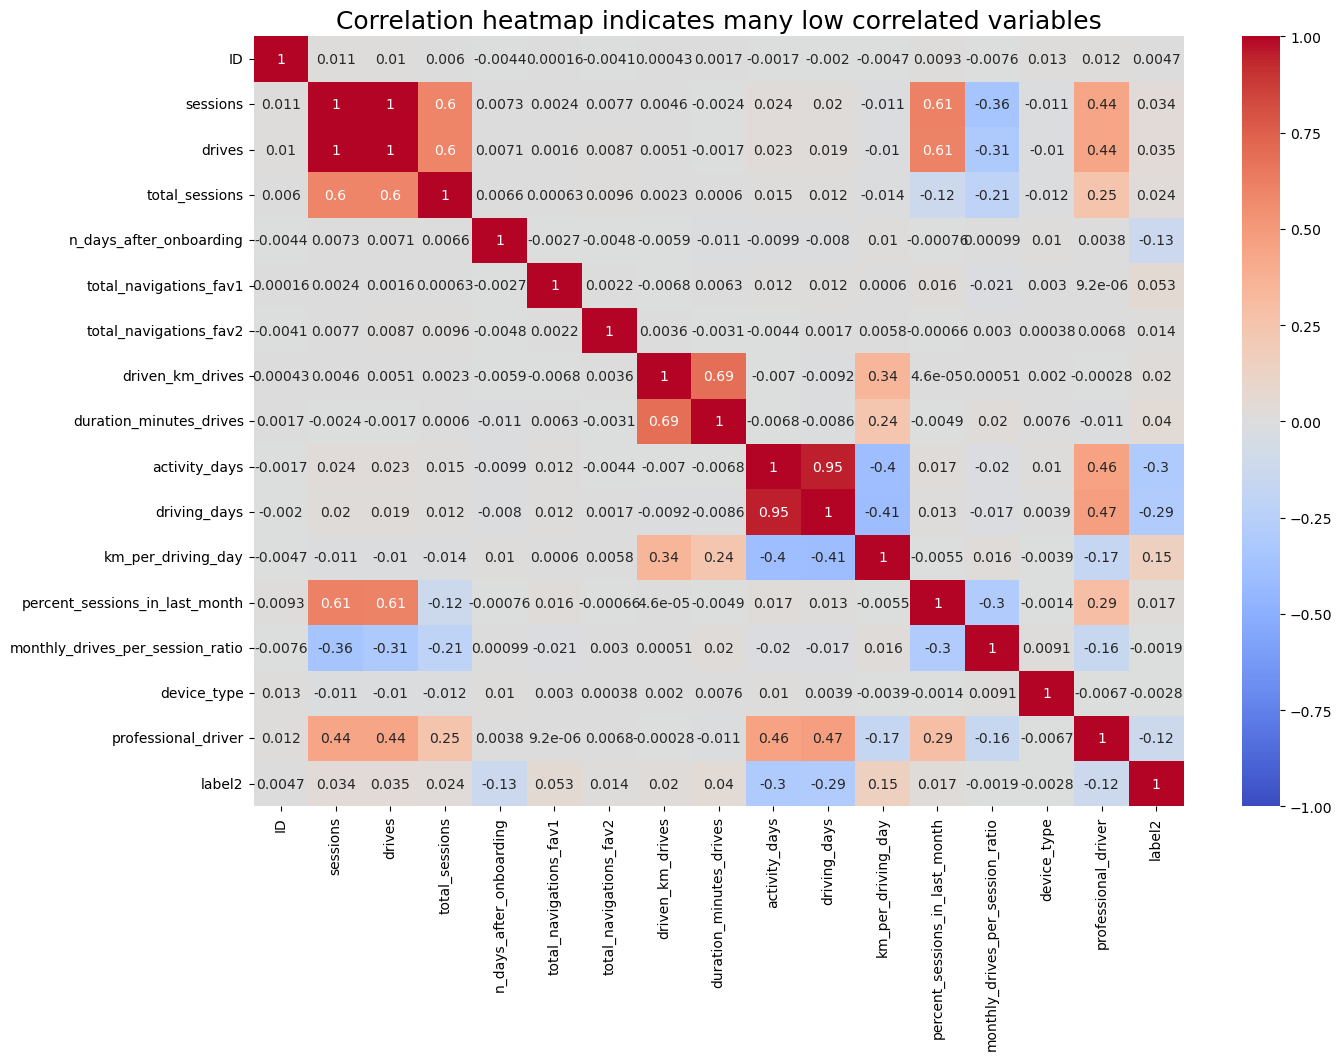

In [64]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap indicates many low correlated variables',
          fontsize=18)
plt.show();

Following variables are multicollinear with each other: 

> * *`sessions` and `drives`: 1.0*
<br>
> * *`driving_days` and `activity_days`: 0.95*

## Building Model

In [65]:
# Isolating predictor variables
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])

In [66]:
# Isolating target variable
y = df['label2']

In [67]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [68]:
X_train.head()

,ID,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,percent_sessions_in_last_month,monthly_drives_per_session_ratio,device_type,professional_driver
10603,10603,74,143.832176,1435,4,120,7955.404762,3308.981969,21,530.360317,0.618777,0.831461,2,1
2986,2986,40,116.882627,2037,82,7,5896.259813,1102.711463,24,393.083988,0.402113,0.851064,1,0
4008,4008,84,249.423269,2994,0,65,2241.301461,838.753734,8,1120.650731,0.356823,0.943820,2,0
1813,1813,23,179.398495,1220,424,35,3293.304213,2426.111422,19,182.961345,0.133780,0.958333,2,0
2817,2817,21,113.202512,823,36,8,6459.932916,3865.917383,14,807.491614,0.229677,0.807692,1,0


In [69]:
model = LogisticRegression(penalty='none', max_iter=400)

model.fit(X_train, y_train)

LogisticRegression(max_iter=400, penalty='none')

In [70]:
pd.Series(model.coef_[0], index = X.columns)

ID                                  0.000004
drives                              0.002022
total_sessions                      0.000136
n_days_after_onboarding            -0.000397
total_navigations_fav1              0.001250
total_navigations_fav2              0.000908
driven_km_drives                   -0.000023
duration_minutes_drives             0.000102
activity_days                      -0.103899
km_per_driving_day                  0.000028
percent_sessions_in_last_month     -0.000609
monthly_drives_per_session_ratio   -0.001193
device_type                        -0.001893
professional_driver                -0.001644
dtype: float64

In [71]:
model.intercept_

array([-0.00138334])

### Verifying the linear relationship between X and the estimated log odds

In [72]:
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.90596446, 0.09403554],
       [0.95695641, 0.04304359],
       [0.84332049, 0.15667951],
       ...,
       [0.95582178, 0.04417822],
       [0.5195602 , 0.4804398 ],
       [0.86221791, 0.13778209]])

In [73]:
# 1. Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# 2. Create a new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

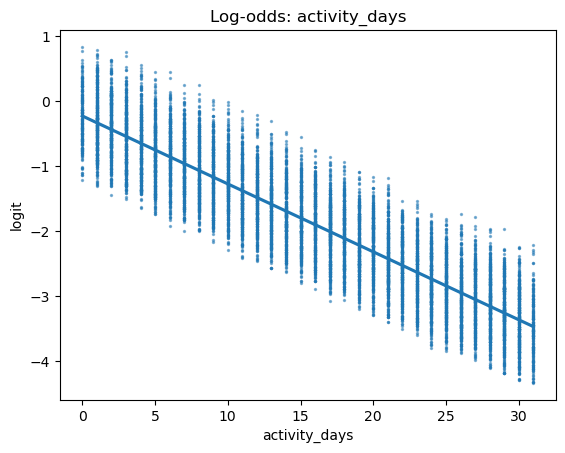

In [74]:
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

### Model result and evaluation

In [75]:
y_preds = model.predict(X_test)

In [76]:
model.score(X_test, y_test)

0.8250704225352112

In [77]:
cm = confusion_matrix(y_test, y_preds)

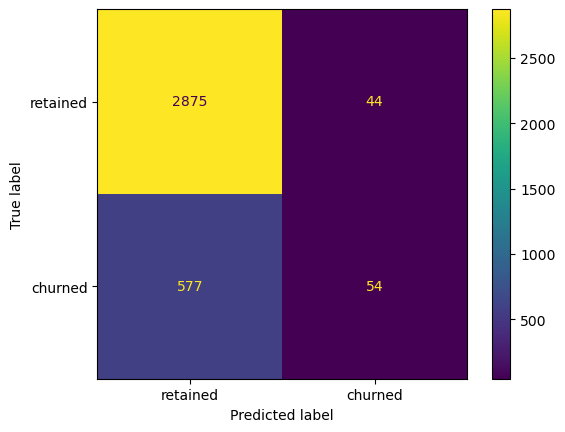

In [78]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot();

In [79]:
precision = cm[1,1] / (cm[0, 1] + cm[1, 1])
precision

0.5510204081632653

In [80]:
recall = cm[1,1] / (cm[1, 0] + cm[1, 1])
recall

0.08557844690966719

In [81]:
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2919
     churned       0.55      0.09      0.15       631

    accuracy                           0.83      3550
   macro avg       0.69      0.54      0.53      3550
weighted avg       0.78      0.83      0.77      3550



The model has mediocre precision and very low recall, which means that it makes a lot of false negative predictions and fails to capture users who will churn.

### Model feature importance

In [82]:
feature_importance = list(zip(X_train.columns, model.coef_[0]))

feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
feature_importance

[('drives', 0.002022022237231597),
 ('total_navigations_fav1', 0.0012501334813275694),
 ('total_navigations_fav2', 0.000908174911011702),
 ('total_sessions', 0.0001360226361451032),
 ('duration_minutes_drives', 0.0001019058330652316),
 ('km_per_driving_day', 2.7610322856285663e-05),
 ('ID', 3.947742018308738e-06),
 ('driven_km_drives', -2.2901273384732393e-05),
 ('n_days_after_onboarding', -0.00039717967604583027),
 ('percent_sessions_in_last_month', -0.0006091341833087736),
 ('monthly_drives_per_session_ratio', -0.0011925464070404463),
 ('professional_driver', -0.0016440531846076106),
 ('device_type', -0.0018929191808052927),
 ('activity_days', -0.10389929895509892)]

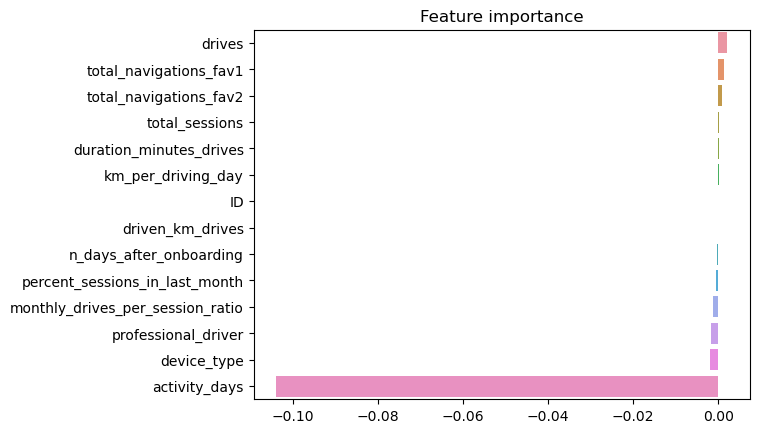

In [83]:
sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature importance');

### Final insights from the model



> _`activity_days` is by far the most important feature in the model. It has a negative correlation with user churn. This was not surprising, as this variable was very strongly correlated with `driving_days`, which was known from EDA to have a negative correlation with churn._


> _As was discovered during EDA, user churn rate increased as the values in `km_per_driving_day` increased. The correlation heatmap revealed this variable to have the strongest positive correlation with churn of any of the predictor variables by a relatively large margin. In the model, it was the second-least-important variable._

> _The model is not a strong enough predictor, as made clear by its poor recall score. However, if the model is only being used to guide further exploratory efforts, then it can have value._

> _New features could be engineered to try to generate better predictive signal. In the case of this model, one of the engineered features (`professional_driver`) was the third-most-predictive predictor. It could also be helpful to scale the predictor variables, and/or to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features._


# Predicting user churn: tree-based models

To get better results from the data, I would like to build and test two tree-based models: random forest and XGBoost

### Feature engineering

I have already created some features in the previous model. Here, I'll engineer some new features to use for modeling.

In [125]:
# Dropping `ID` column as it is useful for our modeling 

df = df.drop(['ID'], axis=1)

#### **`total_sessions_per_day`**


In [126]:
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

In [127]:
df['total_sessions_per_day'].describe()

count    14198.000000
mean         0.329396
std          1.286142
min          0.000298
25%          0.051199
50%          0.100849
75%          0.209106
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`**


In [128]:
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14198.000000
mean       189.596553
std        328.311588
min         72.013095
25%         92.884959
50%        121.191003
75%        191.242678
max      21800.540069
Name: km_per_hour, dtype: float64

These numbers are obviously problematic, further investigations is needed to clarify the unrealistic increase in the km per hour.

#### **`km_per_drive`**

In [129]:
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.419800e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.351409e+01
50%      7.324997e+01
75%      1.785708e+02
max               inf
Name: km_per_drive, dtype: float64

This feature has infinite values. I will convert the infinite values to zero.



In [130]:
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

df['km_per_drive'].describe()

count    14198.000000
mean       227.399001
std        574.116649
min          0.000000
25%         33.503519
50%         73.236370
75%        178.525068
max       8889.794236
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**

Finally, I want to create a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places. 

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [131]:
df['percent_of_drives_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

df['percent_of_drives_to_favorite'].describe()

count    14198.000000
mean         1.508199
std          6.538318
min          0.000000
25%          0.212345
50%          0.645417
75%          1.583451
max        671.949672
Name: percent_of_drives_to_favorite, dtype: float64

### **Evaluation metric**


In [132]:
df['label'].value_counts(normalize=True)

retained    0.822369
churned     0.177631
Name: label, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

It was already determined that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, I will select the model based on the recall score.

### Model building

In [133]:
# 1. Isolating X variables
X = df.drop(columns=['label', 'label2', 'device'])

# 2. Isolating y variable
y = df['label2']

# 3. Splitting into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# 4. Splitting into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

In [134]:
for x in [X_train, X_val, X_test]:
    print(len(x))

8518
2840
2840


This aligns with expectations.

### Random forest

In [135]:
# Instantiating the random forest classifier
rf = RandomForestClassifier(random_state=42)

# Creating a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

# Defining a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiating the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [136]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 1min 21s, sys: 472 ms, total: 1min 22s
Wall time: 1min 22s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring={'precision', 'recall', 'f1', 'accuracy'})

In [137]:
rf_cv.best_score_

0.14540317739526182

In [138]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [139]:
def make_results(model_name:str, model_object, metric:str):

    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    cv_results = pd.DataFrame(model_object.cv_results_)

    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [140]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.500703,0.145403,0.224554,0.821671


Asside from the accuracy, the scores aren't that good. However,  in the earlier logistic regression model the recall was \~0.09, which means that this model has 33% better recall and about the same accuracy, and it was trained on less data.

#### **XGBoost**

 I will try to improve the scores using an XGBoost model.

In [141]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [142]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 3min 11s, sys: 4.05 s, total: 3min 15s
Wall time: 26 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None

In [143]:
xgb_cv.best_score_

0.19166980776479456

In [144]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 300}

In [145]:
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.500703,0.145403,0.224554,0.821671
0,XGB cv,0.435812,0.191670,0.266089,0.812162


This model fit the data even better than the random forest model. The recall score is nearly double the recall score from the logistic regression, and it's almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

### **Model selection**

Now, I will use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

#### **Random forest**

In [146]:
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [147]:
def get_test_scores(model_name:str, preds, y_test_data):

    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [148]:
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.500703,0.145403,0.224554,0.821671
0,XGB cv,0.435812,0.191670,0.266089,0.812162
0,RF val,0.423077,0.130693,0.199697,0.813732


The scores went down from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data.

#### **XGBoost**


In [149]:
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.500703,0.145403,0.224554,0.821671
0,XGB cv,0.435812,0.191670,0.266089,0.812162
0,RF val,0.423077,0.130693,0.199697,0.813732
0,XGB val,0.399061,0.168317,0.236769,0.807042


Just like with the random forest model, the XGBoost model's validation scores were lower, but only very slightly. It is still the clear champion.

### **Using champion model to predict on test data**

Now, I will use the champion model to predict on the test dataset. This is to give a final indication of how we should expect the model to perform on new future data, should we
decide to use the model.

In [150]:
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.500703,0.145403,0.224554,0.821671
0,XGB cv,0.435812,0.191670,0.266089,0.812162
0,RF val,0.423077,0.130693,0.199697,0.813732
0,XGB val,0.399061,0.168317,0.236769,0.807042
0,XGB test,0.400000,0.162698,0.231312,0.808099


The recall dropped slightly, which is within the acceptable range for performance discrepancy between validation and test scores.

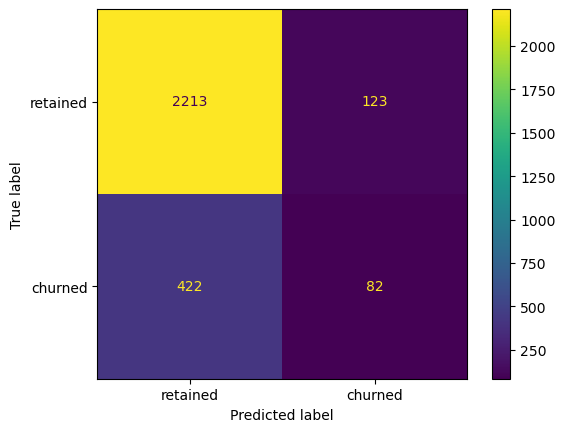

In [152]:
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

The model predicted three times as many false negatives than it did false positives, and it correctly identified only 16.6% of the users who actually churned.

### **Feature importance**


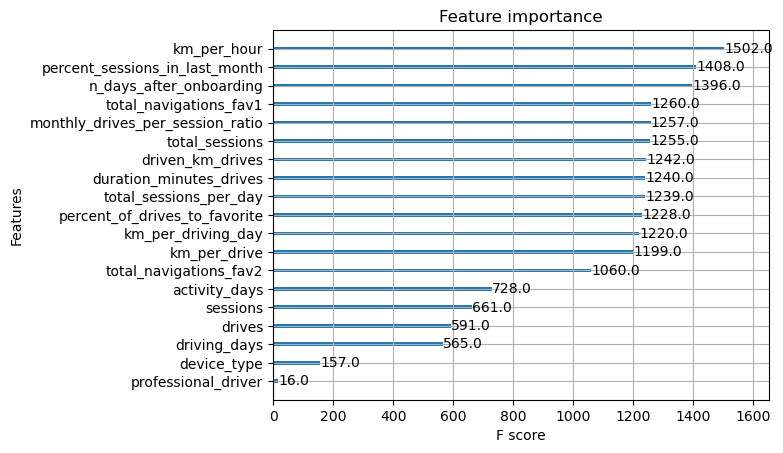

In [154]:
plot_importance(xgb_cv.best_estimator_);

The XGBoost model made more use of many of the features than did the logistic regression model, which weighted a single feature (`activity_days`) very heavily in its final prediction.